In [1]:
from typing import Literal, TypedDict

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from astropy.timeseries import LombScargle
from constants import DATA_DIR

from astrofit.model.enums import SortOptionEnum
from astrofit.utils import (
    AsteroidLoader,
    FrequencyDecomposer,
    LightcurveBinner,
    LightcurvePlotter,
    LightcurveSplitter,
)
from astrofit.utils.enums import BinningMethodEnum

In [2]:
asteroid_loader = AsteroidLoader(DATA_DIR)
lightcurve_binner = LightcurveBinner()
lightcurve_plotter = LightcurvePlotter()
lightcurve_splitter = LightcurveSplitter()
frequency_decomposer = FrequencyDecomposer()

In [3]:
asteroids = sorted((
    asteroid_loader.load_asteroid(name) for name in asteroid_loader.available_asteroids
), key=lambda asteroid: asteroid.period)
asteroids[:5]

[Asteroid(id=29204, name=Ladegast, period=2.031527, lambda=183.0, beta=-78.0, lightcurves=1),
 Asteroid(id=52820, name=1998 RS2, period=2.134122, lambda=58.0, beta=-48.0, lightcurves=1),
 Asteroid(id=7779, name=Susanring, period=2.19003, lambda=151.0, beta=-22.0, lightcurves=1),
 Asteroid(id=138831, name=2000 UD68, period=2.28689, lambda=281.0, beta=-34.0, lightcurves=1),
 Asteroid(id=16118, name=Therberens, period=2.28855, lambda=174.0, beta=-55.0, lightcurves=1)]

In [4]:
len(asteroids)

5057

In [5]:
np.percentile([asteroid.period for asteroid in asteroids], [0, 5, 25, 50, 75, 90, 95, 100])

array([   2.031527,    3.422438,    5.48469 ,    8.78678 ,   16.97036 ,
         49.0198  ,  108.6936  , 1304.1     ])

In [6]:
fig = go.Figure()

fig.add_trace(
    go.Histogram(
        x=[ast.period for ast in asteroids if ast.period < 50],
        histnorm="probability",
    )
)

fig.update_layout(
    title_text="Period frequency (normalized)",
    xaxis_title="Period",
    yaxis_title="Frequency",
    bargroupgap=0.1,
    title_x=0.5,
)
fig.show()

In [7]:
no_lightcurves = [len(asteroid.lightcurves) for asteroid in asteroids]
np.percentile(no_lightcurves, [0, 5, 25, 50, 75, 90, 95, 100])

array([  1.,   1.,   1.,   1.,   2.,   2.,  13., 187.])

In [8]:
no_points = [len(lightcurve.points) for asteroid in asteroids for lightcurve in asteroid.lightcurves]
np.percentile(no_points, [0, 5, 25, 50, 75, 90, 95, 100])

array([1.0000e+00, 8.0000e+00, 2.3000e+01, 4.6000e+01, 1.3100e+02,
       4.1800e+02, 5.1835e+02, 1.0275e+04])

In [9]:
[ast for ast in asteroids if len(ast.lightcurves) > 5][:10]

[Asteroid(id=2102, name=Tantalus, period=2.39006, lambda=36.0, beta=30.0, lightcurves=22),
 Asteroid(id=6053, name=1993 BW3, period=2.57386, lambda=357.0, beta=-12.0, lightcurves=19),
 Asteroid(id=1917, name=Cuyo, period=2.689764, lambda=47.0, beta=-62.0, lightcurves=30),
 Asteroid(id=3749, name=Balam, period=2.804917, lambda=250.0, beta=-71.0, lightcurves=98),
 Asteroid(id=2455, name=Somville, period=2.828681, lambda=39.0, beta=-48.0, lightcurves=12),
 Asteroid(id=321, name=Florentina, period=2.8708658, lambda=267.0, beta=-66.0, lightcurves=11),
 Asteroid(id=1741, name=Giclas, period=2.94252, lambda=288.0, beta=24.0, lightcurves=56),
 Asteroid(id=1117, name=Reginita, period=2.946471, lambda=174.0, beta=49.0, lightcurves=17),
 Asteroid(id=3787, name=Aivazovskij, period=2.953347, lambda=22.0, beta=-48.0, lightcurves=7),
 Asteroid(id=1103, name=Sequoia, period=3.037976, lambda=60.0, beta=-59.0, lightcurves=12)]

In [42]:
asteroid, = [asteroid for asteroid in asteroids if asteroid.name == "Tantalus"]
asteroid

Asteroid(id=2102, name=Tantalus, period=2.39006, lambda=36.0, beta=30.0, lightcurves=22)

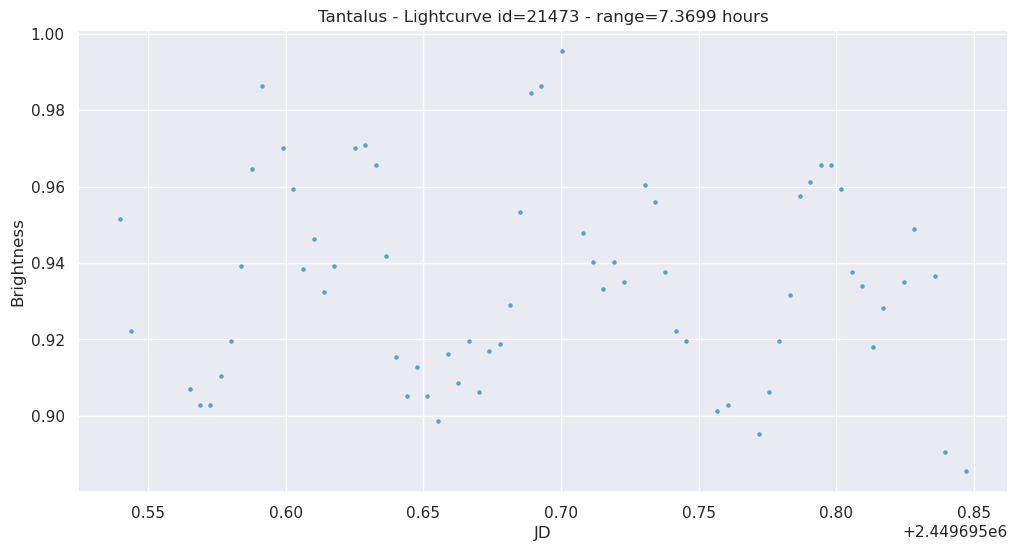

In [43]:
asteroid.get_longest_lightcurve(by=SortOptionEnum.PERIOD).plot(asteroid_name=asteroid.name)

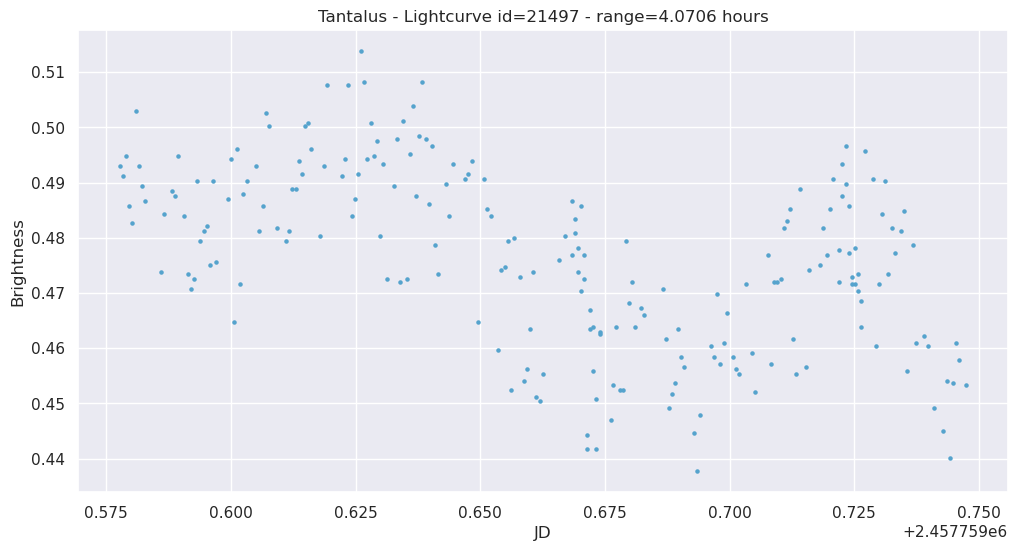

In [44]:
asteroid.get_longest_lightcurve(by=SortOptionEnum.POINTS).plot(asteroid_name=asteroid.name)

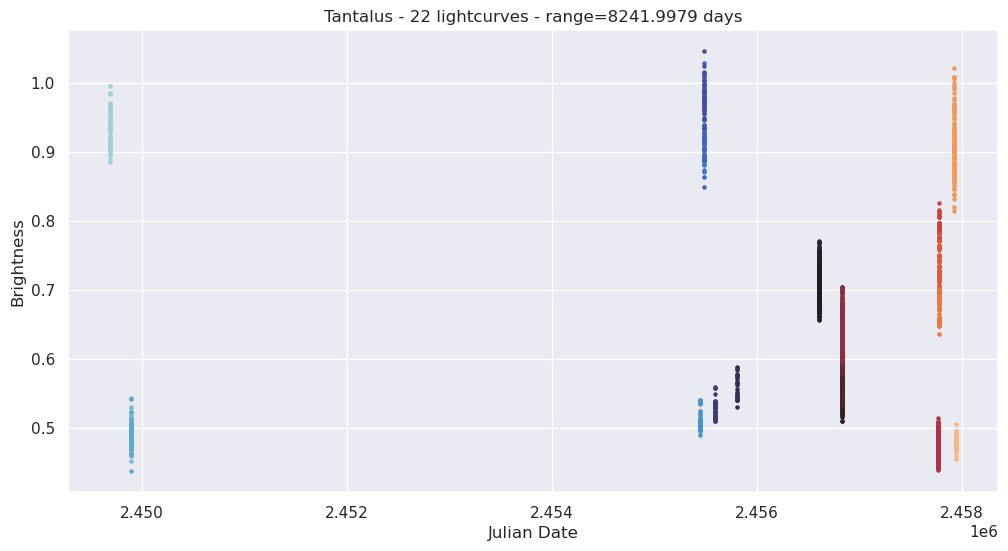

In [45]:
lightcurve_plotter.plot_lightcurves(asteroid.lightcurves, split_plots=False, asteroid_name=asteroid.name)

In [46]:
splitted = lightcurve_splitter.split_lightcurves(
    asteroid.lightcurves,
    max_hours_diff=24,
    min_no_points=10,
)
splitted[:5]

[Lightcurve(id=21473, period=7.36992h, points_count=66, first_JD=2449695.53986, last_JD=2449695.84694),
 Lightcurve(id=21474, period=3.90552h, points_count=64, first_JD=2449897.36358, last_JD=2449897.52631),
 Lightcurve(id=21475, period=2.49504h, points_count=34, first_JD=2449898.43204, last_JD=2449898.536),
 Lightcurve(id=21476, period=2.44558h, points_count=37, first_JD=2455439.812308949, last_JD=2455439.914207921),
 Lightcurve(id=21477, period=1.00363h, points_count=23, first_JD=2455482.825765979, last_JD=2455482.867583778)]

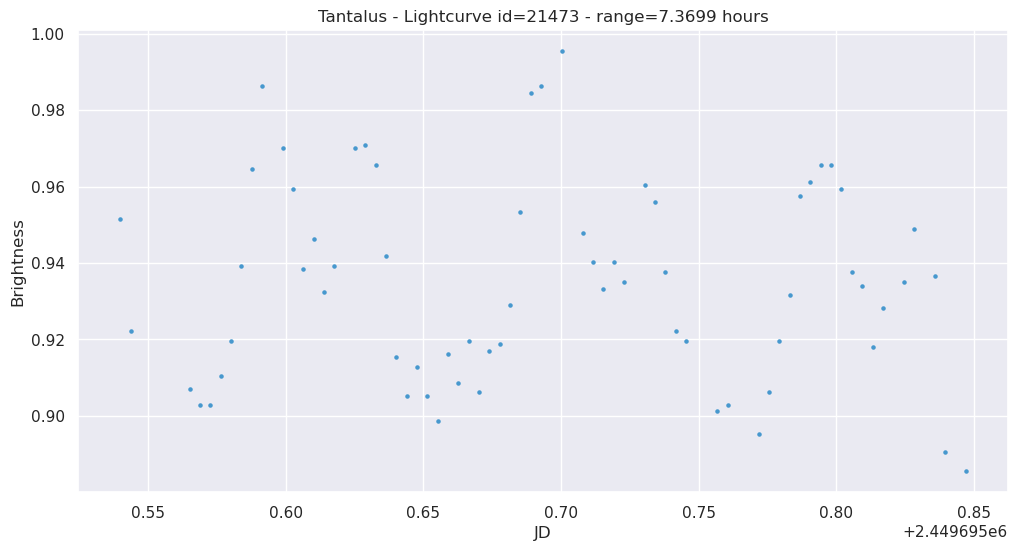

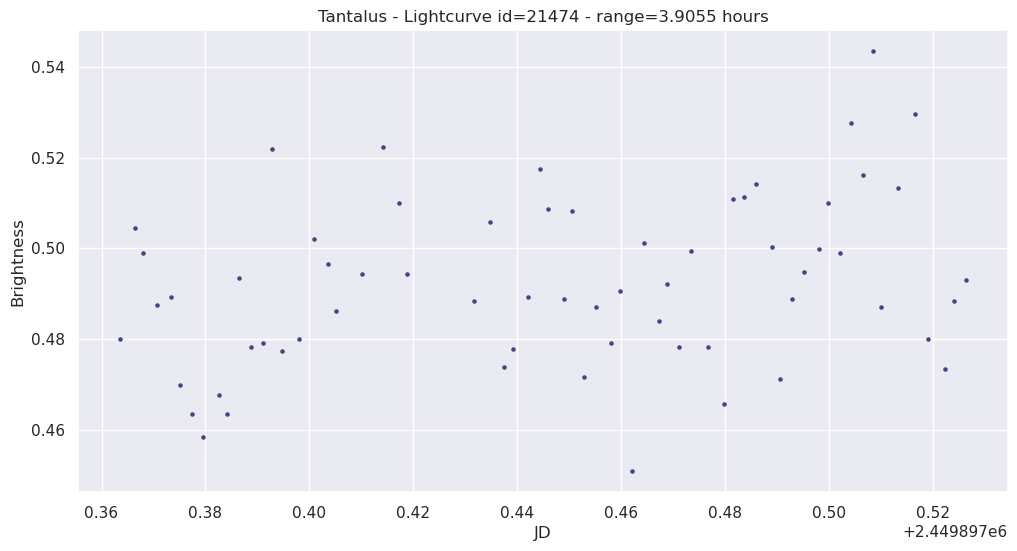

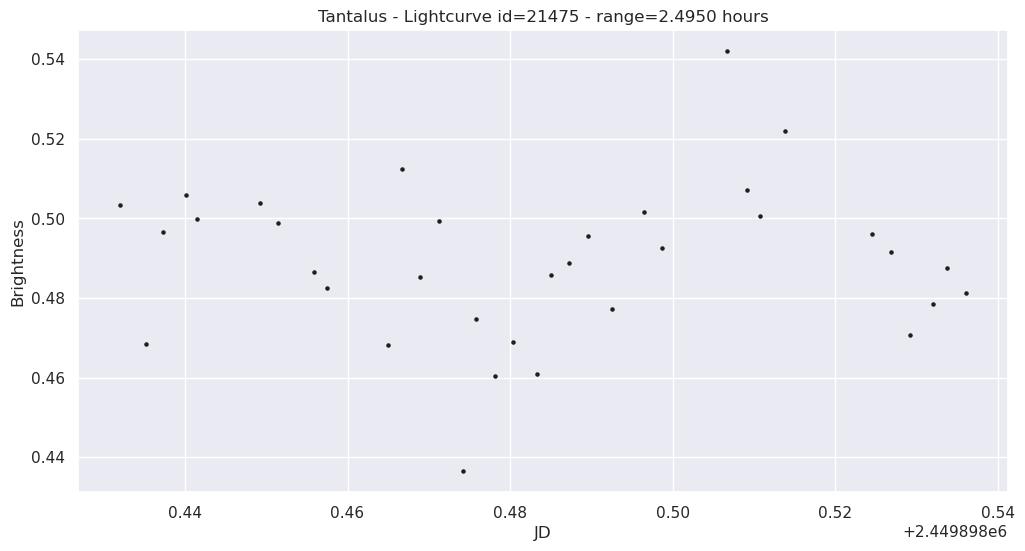

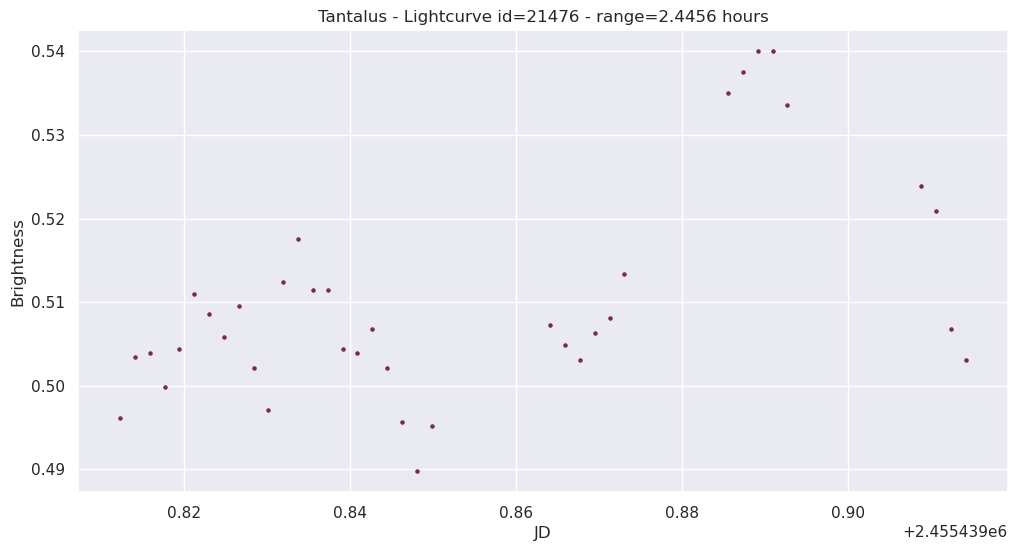

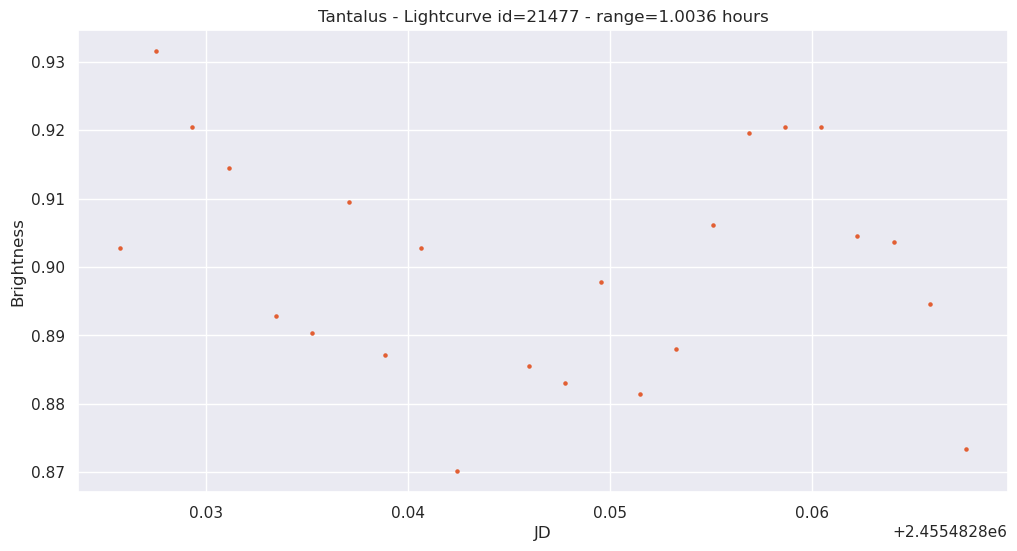

In [47]:
lightcurve_plotter.plot_lightcurves(splitted[:5], split_plots=True, asteroid_name=asteroid.name)

In [48]:
bins = lightcurve_binner.bin_lightcurves(
    splitted,
    max_time_diff=45,
    binning_method=BinningMethodEnum.FIRST_TO_FIRST_DIFF,
)
bins = sorted(bins, key=lambda bin: bin.points_count, reverse=True)
bins

[LightcurveBin(lightcurves=5, period=4.28849h, points=489),
 LightcurveBin(lightcurves=4, period=12.10519h, points=339),
 LightcurveBin(lightcurves=2, period=1.98636h, points=217),
 LightcurveBin(lightcurves=2, period=21.79453h, points=163),
 LightcurveBin(lightcurves=4, period=45.04587h, points=142),
 LightcurveBin(lightcurves=2, period=1.17242h, points=98),
 LightcurveBin(lightcurves=1, period=7.36992h, points=66),
 LightcurveBin(lightcurves=1, period=1.80459h, points=46),
 LightcurveBin(lightcurves=1, period=1.38088h, points=23)]

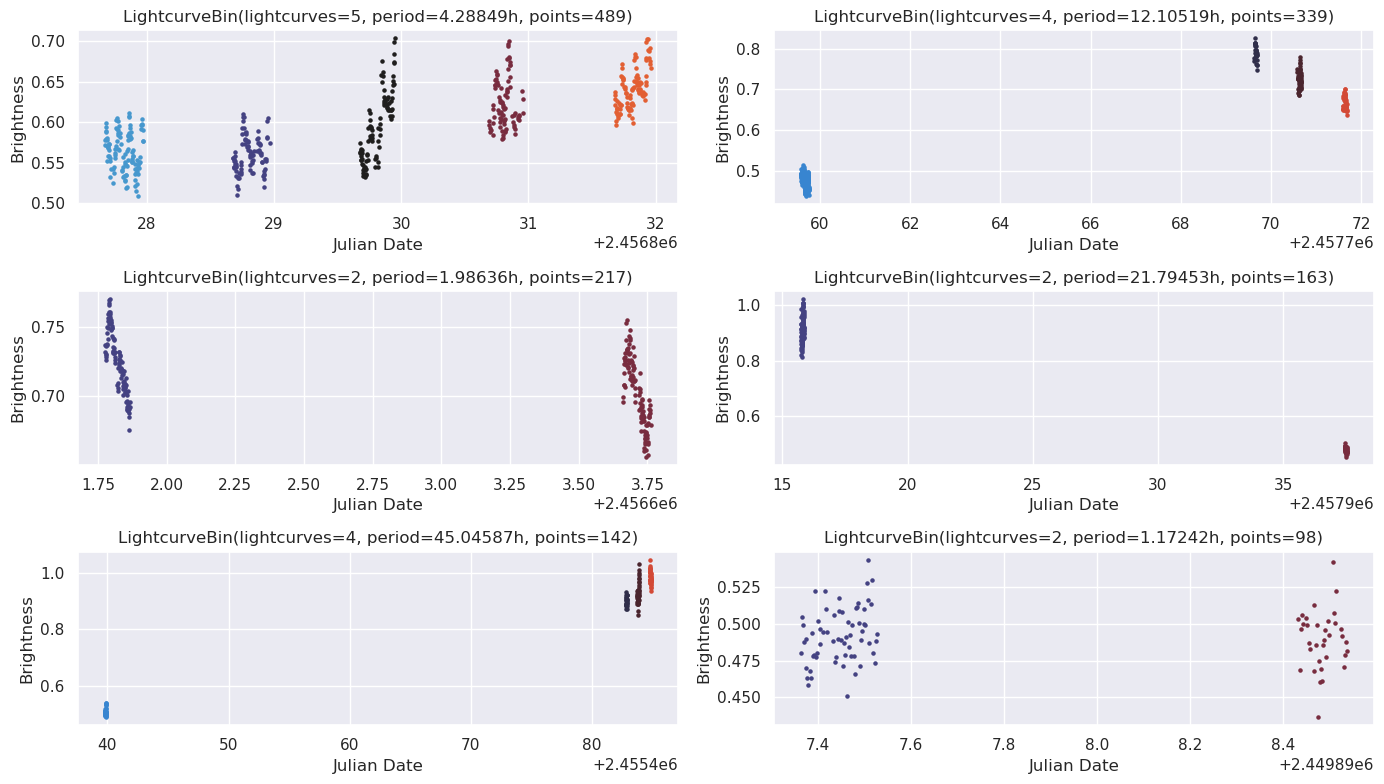

In [49]:
lightcurve_plotter.plot_bins_on_grid(bins[:6])

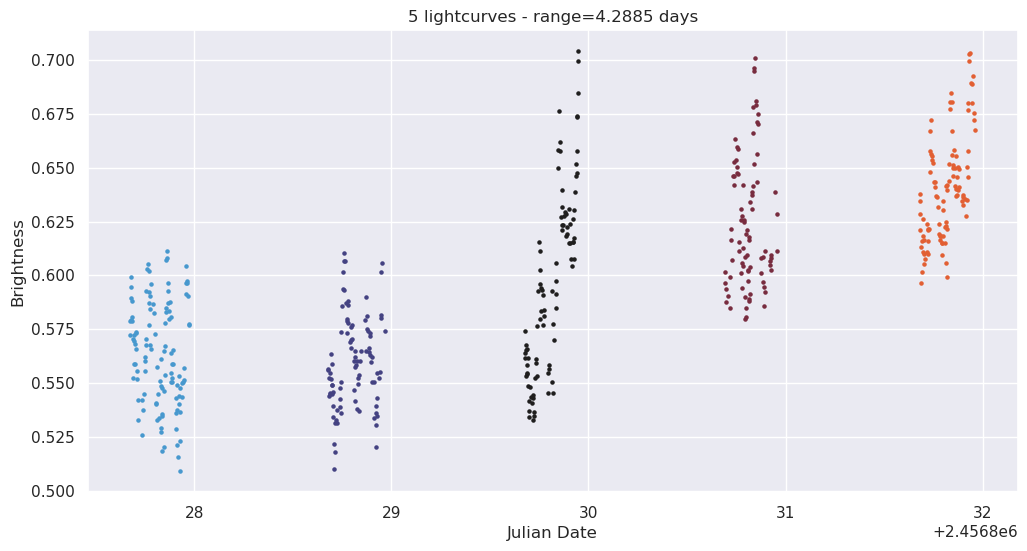

In [50]:
_bin = bins[0]
lightcurve_plotter.plot_lightcurves(_bin, split_plots=False)

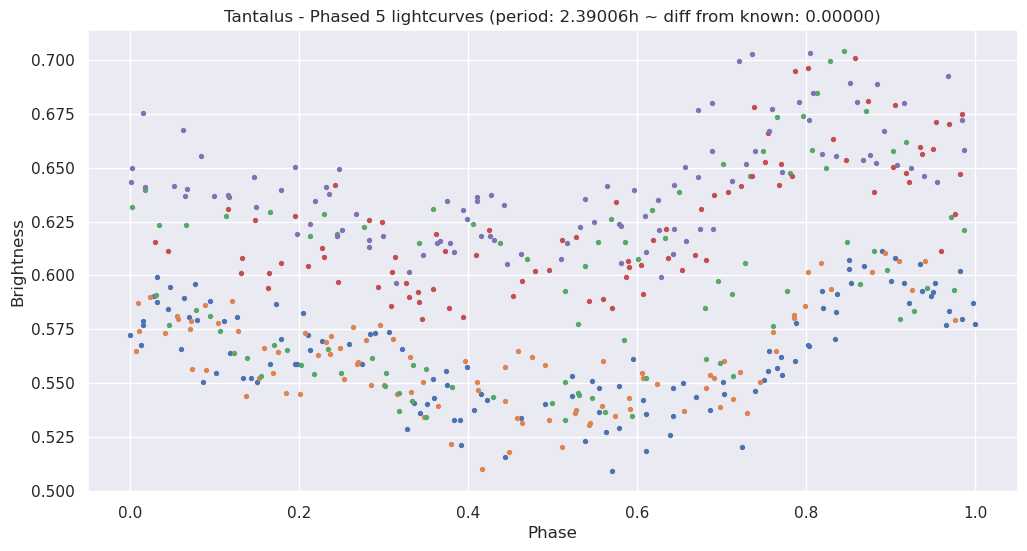

In [51]:
lightcurve_plotter.plot_phased_lightcurves(
    _bin, period=asteroid.period, known_period=asteroid.period, asteroid_name=asteroid.name
)

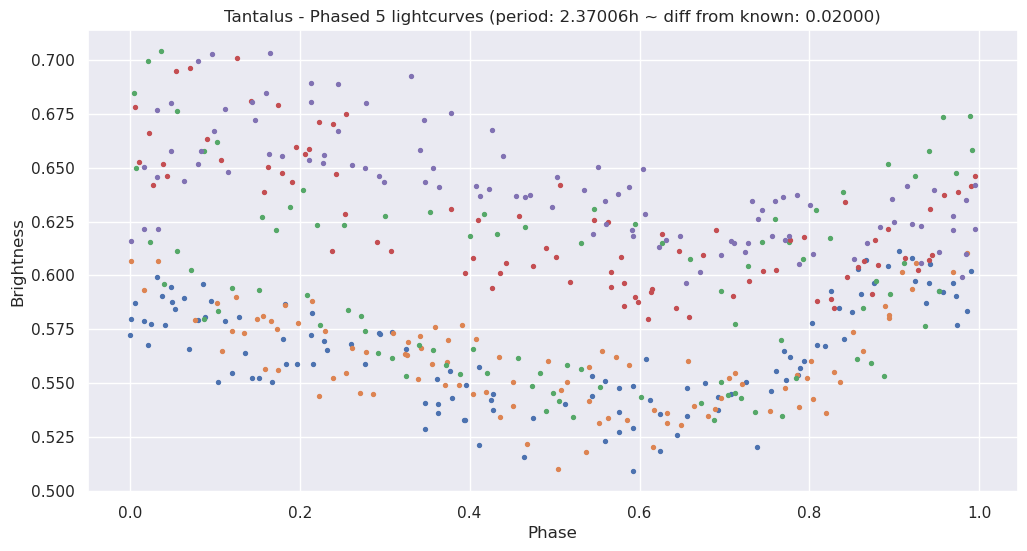

In [52]:
lightcurve_plotter.plot_phased_lightcurves(
    _bin, period=asteroid.period - 0.02, known_period=asteroid.period, asteroid_name=asteroid.name
)

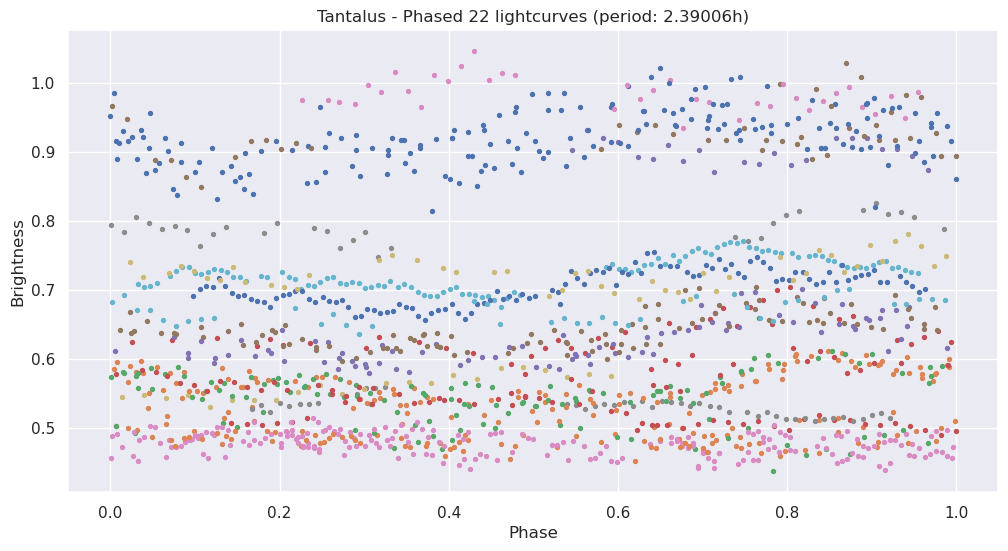

In [53]:
lightcurve_plotter.plot_phased_lightcurves(asteroid.lightcurves, period=asteroid.period, asteroid_name=asteroid.name)

In [54]:
print(f"Asteroid period: {asteroid.period:>9}")
print(f"Target frequency: {24 * 1 / asteroid.period:.6f}")

Asteroid period:   2.39006
Target frequency: 10.041589


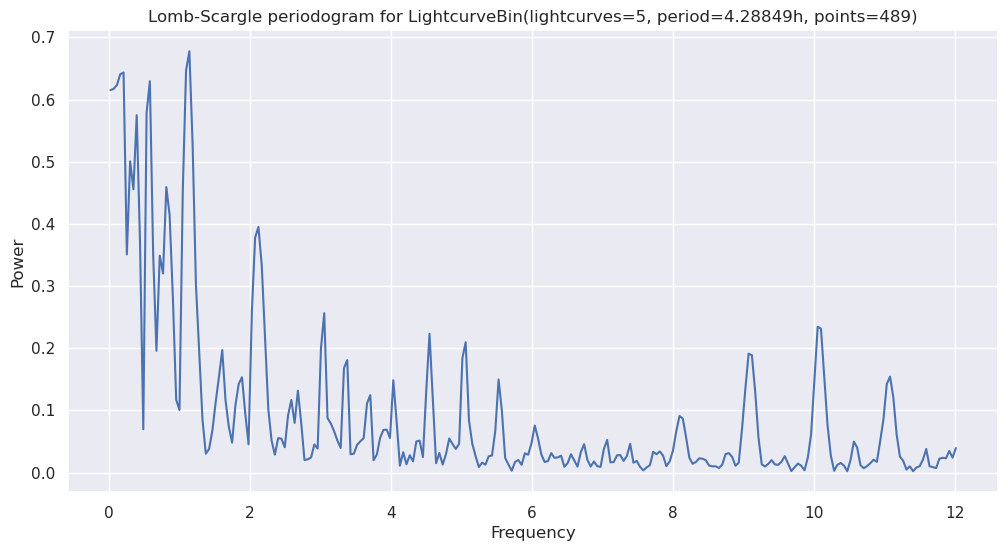

array([[ 1.14259379,  0.67762106],
       [ 1.09595731,  0.64669948],
       [ 0.20986417,  0.64344385],
       [ 0.16322768,  0.64064812],
       [ 0.58295602,  0.62944402],
       [ 0.1165912 ,  0.6234208 ],
       [ 0.06995472,  0.61721559],
       [ 0.02331824,  0.61510983],
       [ 0.53631954,  0.57868002],
       [ 0.39641009,  0.57481678],
       [ 1.18923027,  0.52650241],
       [ 0.30313713,  0.50066526],
       [ 0.81613842,  0.45910391],
       [ 0.34977361,  0.45556074],
       [ 1.04932083,  0.45215148],
       [ 0.86277491,  0.4142316 ],
       [ 2.1219599 ,  0.39498267],
       [ 2.07532342,  0.37806   ],
       [ 0.44304657,  0.3708801 ],
       [ 0.6295925 ,  0.35124431],
       [ 0.25650065,  0.35078314],
       [ 0.72286546,  0.34882766],
       [ 2.16859638,  0.3337104 ],
       [ 0.76950194,  0.32022077],
       [ 1.23586676,  0.30224595],
       [ 0.90941139,  0.28035805],
       [ 2.02868694,  0.2590036 ],
       [ 3.05468953,  0.25637862],
       [10.05016174,

In [55]:
frequency_decomposer.decompose_bin(_bin, fourier_nterms=3, top_k=50, max_freq=12, show_plot=True)